## Simulation-Based Inference: Type1a Supernovae
> Created: March 21, 2023, CLASHEP 2023, San Esteban, Chile, Harrison B. Prosper<br>
> Updated: April 7, 2023 HBP

### Introduction 

The likelihood function for the data from Type1a supernovae, namely, distance moduli and redshifts, is known: it is a multivariate Gaussian. However, there are many situations in which the likelihood function is intractable. But if a high-fidelity simulator of the data generation mechanism is available then the simulator can be used to simulate an instance of the data for any given point in the parameter space of the scientific model.
In this notebook, we illustrate the use of simulation-based inference[1] (also known by the misnomer likelihood-free inference) to infer the parameters of a cosmological model from the Supernova Cosmology Project Union 2.1 compilation of distance-redshift data for 580 Type1a supernovae. 

The cosmological model is defined by the dimensionless energy density 

\begin{equation}
    \Omega(a) = \exp(a^n - 1) \, / \, a^3,
\end{equation}

where the index $n$ and the Hubble constant $H_0$ are the parameters of the model. See notebook __phantom_model.ipynb__ for details. 

### Test statistic
We use the test statistic 

\begin{align}
    \lambda(D, \theta) & = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(\frac{x_i - \mu(z_i, \theta)}{\sigma_i}\right)^2},
\end{align}

See __01_phantom_simdata.ipynb__ for details.

The standard deviation $\sigma_i$ is a measure of the accuracy of the distance modulus measurement. In the simulations, we assume that the redshifts and standard deviations are known with high precision and that only variations in the distance moduli $D = \{ x_i \}$ are simulated. For the Union 2.1 compilation the standard deviations vary from one supernova to the next. Data in which the accuracy of the measurements vary are referred to as *heteroscedastic* data. Notice that the test statistic gives greater weight to distance moduli measured with greater accuracy. 


### Approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

The quantity $\mathbb{E}(Z | \theta)$ can be approximated using the following algorithm. 

$\theta = n, H_0$

  1. Create histogram $h_w \gets \text{histogram}(n, H_0, \text{weight}=Z)$
  1. Create histogram $h_u \gets \text{histogram}(n, H_0, \text{weight}=1)$
  1. Approximate $\mathbb{P}(\lambda \le \lambda_0 | n, H_0)$ by $h_w \, / \, h_u$

In this notebook, we using uniform binning since there are only two parameters, but for $n$-dimensional data it is better to bin using, for example, binary partitioning (see,  [turtlebinning](https://github.com/hbprosper/turtle)). Histogram-based approximations of $\mathbb{P}(\lambda \le \lambda_0 | \theta)$ provide a rough way to check the quality of the deep neural network model.

### References
  1. Anne Lee *et al.*, https://arxiv.org/abs/2107.03920

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

### Load and define cosmological model functions

In [3]:
%run phantom_model.ipynb

### Some data preparation utilities

| __function__   | __description__     |
| :---           | :---                |
| split_data | split data into train, validation, and test sets|
| dataframe2tensor | convert from a pandas dataframe to Pytorch tensors |
 

In [4]:
# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# if cuda-based GPUs are available, then use them
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)

def split_data(data,
               test_fraction, 
               validation_fraction):
    
    # split data into a part for training and a part for testing.
    # shuffle the rows.
    train_data, test_data = train_test_split(data, 
                                         test_size=test_fraction, 
                                         shuffle=True)

    # split the training data into a part for training (fitting) and
    # a part for validating while training.
    train_data, valid_data = train_test_split(train_data, 
                                          test_size=validation_fraction,
                                          shuffle=True)

    # reset the indices in the dataframes and drop the old ones
    train_data = train_data.reset_index(drop=True)
    valid_data = valid_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)
    
    return train_data, valid_data, test_data 


def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device. If the device is a GPU
    # then the data will be loaded to that device.
    x = torch.tensor(df[source].to_numpy()).float().to(device)
    t = torch.tensor(df[target].to_numpy()).int().to(device)
    return (x, t)

device: cpu


### Load data

__Note__: It is good practice to transform the input values to the ML model so that they are  of $\cal{O}(1)$.

In [5]:
# read simulated Type1a data that mimick the real data for 580 supernova

datafile = 'data/type1a_simdata.csv.gz'
print('loading %s' % datafile)
tdata = pd.read_csv(datafile)

# get (unscaled) boundaries of parameter subspace 
xmin  = int(10*(tdata.n.min()+0.01))/10
xmax  = int(10*(tdata.n.max()+0.01))/10

ymin  = int(10*(tdata.H0.min()+0.01))/10
ymax  = int(10*(tdata.H0.max()+0.01))/10

# put everything into a bag called for convenience
class Bag:
    pass

bag = Bag()
bag.name   = 'phantom'

bag.weight = 'Z0'  # see hist_data
bag.xscale = 10    # scale by which to reduce "n" parameter
bag.xbins  = 10
bag.xmin   = xmin / bag.xscale
bag.xmax   = xmax / bag.xscale
bag.xstep  = 1    / bag.xscale
bag.xname  = 'n'
bag.xlabel = 'n'

bag.yscale = 100   # scale by which to reduce "H0" parameter
bag.ybins  = 10
bag.ymin   = ymin / bag.yscale
bag.ymax   = ymax / bag.yscale
bag.ystep  = 2    / bag.yscale
bag.yname  = 'H0'
bag.ylabel = 'H_0'

filename   = 'data/type1a_union2.1.txt'

bag.z, bag.x, bag.dx = read_data(filename)

# reduce the dynamic range of parameters n and H0
tdata.n   /= bag.xscale
tdata.H0  /= bag.yscale

features   = ['lo', 'n', 'H0']  # inputs into ML model
target     = 'Zo'               # targets for ML model

print()
print('number of rows:', len(tdata))
print(f'xmin: {bag.xmin:4.2f}, xmax: {bag.xmax:4.2f}')
print(f'ymin: {bag.ymin:4.2f}, ymax: {bag.ymax:4.2f}')

tdata[:5]

loading data/type1a_simdata.csv.gz
number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

number of rows: 275000
xmin: 0.05, xmax: 0.60
ymin: 0.66, ymax: 0.76


,n,H0,l,l0,lo,Z0,Zo
0,0.393632,0.730757,1.006532,1.015473,0.970374,1,0
1,0.292003,0.696037,0.991506,1.006351,1.541803,1,1
2,0.365906,0.708710,1.034574,1.024765,1.057431,0,1
3,0.553187,0.739221,0.988936,1.093398,1.444401,1,1
4,0.421428,0.681756,1.041732,1.340285,1.770373,1,1


In [6]:
tdata.lo.mean(), tdata.lo.std()

(1.4746658576610931, 0.4662719051601046)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [7]:
# Fraction of the data assigned as test data and validation
tfraction =  20/275   # initial testing fraction
vfraction =   5/255   # validation fraction

# Split data into a part for training and a part for testing
train_data, valid_data, test_data = split_data(tdata, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

train_x, train_t = dataframe2tensor(train_data, target, features)
valid_x, valid_t = dataframe2tensor(valid_data, target, features)
test_x,  test_t  = dataframe2tensor(test_data,  target, features)

print('train set size:        %6d' % train_x.shape[0])
print('validation set size:   %6d' % valid_x.shape[0])
print('test set size:         %6d' % test_x.shape[0])

train set size:        250000
validation set size:     5000
test set size:          20000


### Approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

In [8]:
def hist_data(df, data):

    xbins, xmin, xmax = data.xbins, data.xmin, data.xmax
    ybins, ymin, ymax = data.ybins, data.ymin, data.ymax
    
    xrange = (xmin, xmax)
    yrange = (ymin, ymax)
    
    x      = df[data.xname]
    y      = df[data.yname]

    # weighted histogram   (count the number of ones per bin)
    hw, xedges, yedges = np.histogram2d(x, y, 
                                        bins=(xbins, ybins), 
                                        range=(xrange, yrange), 
                                        weights=df[data.weight])
    
    # unweighted histogram (count number of ones and zeros per bin)
    hu, xedges, yedges = np.histogram2d(x, y, 
                                        bins=(xbins, ybins), 
                                        range=(xrange, yrange)) 
    p =  hw / (hu + 1.e-10)    
    
    return p, xedges, yedges

In [9]:
h2d = hist_data(tdata, bag)

In [10]:
def plot_model(df, d, dnn=None, hist=None, results=None, 
               plothist=True, colormap='rainbow',
               filename='phantom_results.png', 
               fgsize=(5, 5), ftsize=18):
        
    # approximate probability via histogramming
    # P:  bin contents as a 2D (xbins, ybins) array

    xbins, xmin, xmax = d.xbins, d.xmin, d.xmax
    ybins, ymin, ymax = d.ybins, d.ymin, d.ymax
    
    if hist:
        P, _, _ = hist
    else:
        P, _, _ = hist_data(df, d)
        
    # get bin centers
    xstep = (xmax - xmin)/xbins
    ystep = (ymax - ymin)/ybins
    x   = np.arange(xmin+xstep/2, xmax, xstep)
    y   = np.arange(ymin+ystep/2, ymax, ystep)
    X,Y = np.meshgrid(x, y)

    # WARNING: must transpose P so that X, Y, and P have the
    # same shape
    P   = P.T
    if not (X.shape == Y.shape == P.shape):
        raise ValueError('shapes of X, Y, P differ')
            
    # Now make plots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$%s$' % d.xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+d.xstep, d.xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$%s$' % d.ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+d.ystep, d.ystep))
    
    if plothist:
        x = X.flatten()
        y = Y.flatten()
        p = P.flatten()
        h = ax.hist2d(x, y,
                      range=((xmin, xmax), 
                             (ymin, ymax)),
                      bins=(xbins, ybins), 
                      weights=p, cmap=colormap)
    
        fig.colorbar(h[3], ax=ax)
        
    # plot contours at specified values of P(l < l0 | theta)
    mylevels = np.array([0.68, 0.80, 0.90, 0.95])
    cs = ax.contour(X, Y, P, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               linestyles='dashed',
               cmap=colormap)
    
    # ----------------------------------------------
    # compute model output at every grid point
    # then reshape to a 2d array
    # ----------------------------------------------
    if dnn:
        xbins,ybins= 50, 50        
        xstep = (xmax - xmin)/xbins
        ystep = (ymax - ymin)/ybins
        x     = np.arange(xmin+xstep/2, xmax, xstep)
        y     = np.arange(ymin+ystep/2, ymax, ystep)
        X, Y  = np.meshgrid(x, y)
        x     = X.flatten()
        y     = Y.flatten()
        F     = dnn(x, y, d).reshape(X.shape)

        cs = ax.contour(X, Y, F, 
                    extent=(xmin, xmax, ymin, ymax),
                    levels=mylevels, 
                    linewidths=2,
                    cmap=colormap) 

        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=18, fmt='%4.2f', 
              colors='black')
    
    if results:
        if results.success:
            x, y = results.x
            ax.scatter(x, y, s=50, c='black')

            xpos = xmin + 0.1*(xmax-xmin)
            ypos = ymin + 0.9*(ymax-ymin)
            ax.text(xpos, ypos, 
                    r'$%s: %8.3f$\,\,$%s: %8.1f$' % (d.xlabel, x*d.xscale, 
                                                     d.ylabel, y*d.yscale), 
                    fontsize=ftsize)
        
    ax.grid()

    plt.tight_layout()

    print('saved to file:', filename)
    plt.savefig(filename)
        
    plt.show()

saved to file: fig_phantom_hist.pdf


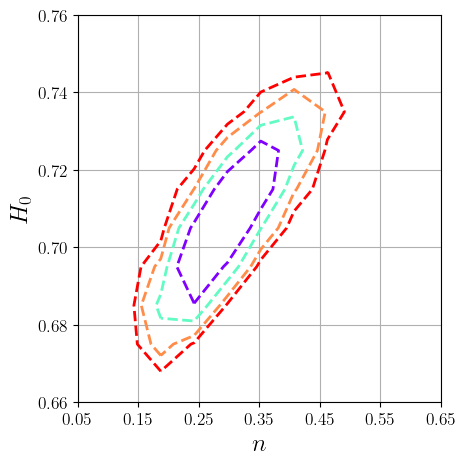

In [11]:
plot_model(test_data, bag, hist=h2d,
           plothist=False, colormap='rainbow', 
           filename='fig_phantom_hist.pdf')

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_M(\theta) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta).
\end{align*}

The empirical risk $R_M$ approximates the __risk functional__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x} .
\end{align}

The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

We use the __quadratic loss__

\begin{align}
    L(t, f) &= (t - f)^2 .
\end{align}

### Define model $f(\lambda, n, H_0; \omega)$

For simple models, it is sufficient to use the __Sequential__ class.

In [12]:
%%writefile phantom_dnn.py

name     = 'phantom'
features = ['lo', 'n', 'H0']
target   = 'Zo'
nodes    = 20

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear( len(features), nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, 1), 
                      nn.Sigmoid()) 

Overwriting phantom_dnn.py


In [13]:
# return a random batch of data for the next step in minimization
def get_random_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows  = np.random.choice(len(x), batch_size)
    return x[rows], t[rows]

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x=None):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x=None):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, x, t):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        # reshape to ensure that y and t are of the same shape!
        y = model(x).reshape(t.shape)
    return avloss(y, t, x)
        
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
        
def train(model, optimizer, dictfile, early_stopping_count,
          avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size,
          n_iterations, 
          traces, 
          step=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    # save model with smallest validation loss
    # if after early_stopping_count iterations 
    # no validation scores are lower than the
    # current lowest value.
    min_acc_v = 1.e30
    stopping_count = 0
    jjsaved = 0
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%9s %9s %9s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):
                
        stopping_count += 1
            
        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        x, t = getbatch(train_x, train_t, batch_size)     
            
        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with y and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        y = model(x).reshape(t.shape)
               
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(y, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if acc_v < min_acc_v:
                min_acc_v = acc_v
                torch.save(model.state_dict(), dictfile)
                stopping_count = 0
                jjsaved = ii
            else:
                if stopping_count > early_stopping_count:
                    print('\n\nstopping early!')
                    break
                    
            if len(xx) < 1:
                xx.append(0)
                print("%9d %9.7f %9.7f" % (xx[-1], acc_t, acc_v))
            elif len(xx) < 5:
                xx.append(xx[-1] + step)
                print("%9d %9.7f %9.7f" % (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                saved = ' %9d: %9d/%10.8f/%9d' % \
                (ii, jjsaved, min_acc_v, stopping_count)
                print("\r%9d %9.7f %9.7f%s" % \
                      (xx[-1], acc_t, acc_v, saved), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
                
    print()
    
    model.load_state_dict(torch.load(dictfile))
    return (xx, yy_t, yy_v)

def plot_average_loss(traces, ftsize=18):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

In [14]:
import phantom_dnn as NN
importlib.reload(NN)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

name     = NN.name
modelfile= f'{name:s}.dict'
model    = NN.model.to(device)
features = NN.features
target   = NN.target
print(name)
print(model)
print('number of parameters: %d' % number_of_parameters(model))

phantom
Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): ReLU()
  (10): Linear(in_features=20, out_features=1, bias=True)
  (11): Sigmoid()
)
number of parameters: 1781


### Train!

In [15]:
traces = ([], [], [])
traces_step = 10

Iteration vs average loss
iteration train-set valid-set
        0 0.2845033 0.2845834
       10 0.2652703 0.2652544
       20 0.2418623 0.2417004
       30 0.2084271 0.2080070
       40 0.1592540 0.1584877
   156090 0.0232036 0.0218343    156090:    106090/0.02105632/    50000

stopping early!



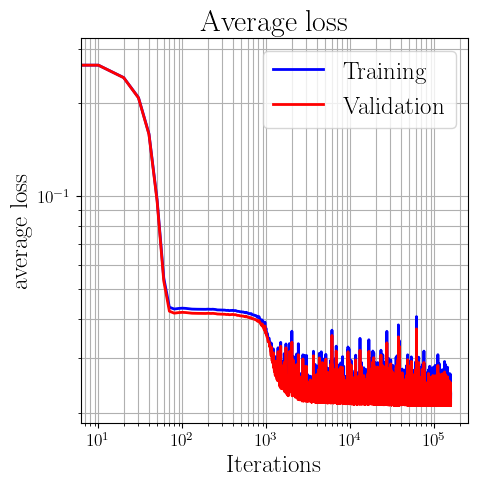

In [20]:
n_batch       =     50
n_iterations  =1000000
early_stopping=  50000
learning_rate = 1.e-3

optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = train(model, optimizer, 
                  modelfile, early_stopping,
                  average_quadratic_loss,
                  get_random_batch, 
                  train_x, train_t, 
                  valid_x, valid_t,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

plot_average_loss(traces)

In [20]:
def nll(params, *args):
    a, b = params
    dnn, d = args
    return dnn(a, b, d)

def best_fit(nll, dnn, d):
    # ----------------------------------------------
    # find best-fit value
    # ----------------------------------------------
    n = 0.55*(d.xmax+d.xmin)
    H = 0.55*(d.ymax+d.ymin)
    guess   = [n, H]
    results = op.minimize(nll, guess, 
                          args=(dnn, d), 
                          method='Nelder-Mead')
    return results

def test_statistic(x, y, d):
    
    np_array = type(x) == type(np.array([0]))
    
    if np_array:
        N = len(x)
        s = np.zeros(N)
        for i, n, H in zip(range(N), x, y):
            n *= d.xscale
            H *= d.yscale
            mu = distance_modulus(d.z, n, H)
            c  = (d.o - mu)/d.dx   # compute for current hypothesis
            s[i] = (c**2).mean()
    else:
        n  = x * d.xscale
        H  = y * d.yscale
        mu = distance_modulus(d.z, n, H)
        c  = (d.o - mu)/d.dx   # compute for current hypothesis
        s  = (c**2).mean()

    return np.sqrt(s)

def cdf(l, n, H, f=model):
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    X = torch.Tensor(np.array([l, n, H]).T)
    Y = model(X).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

def dnn(n, H, d, f=model):
    l = test_statistic(n, H, d)
    return cdf(l, n, H, f)

In [21]:
Load_model = True
modelfile  = '%s.dict' % NN.name
print('load model: %s' % modelfile)

if Load_model:
    modeldict = torch.load(modelfile)
    NN.model.load_state_dict(modeldict)

load model: phantom.dict


### Plot results of trained model

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.37057459354400635
             x: [ 2.806e-01  7.040e-01]
           nit: 37
          nfev: 70
 final_simplex: (array([[ 2.806e-01,  7.040e-01],
                       [ 2.805e-01,  7.040e-01],
                       [ 2.806e-01,  7.040e-01]]), array([ 3.706e-01,  3.706e-01,  3.706e-01]))
saved to file: fig_phantom_results.pdf


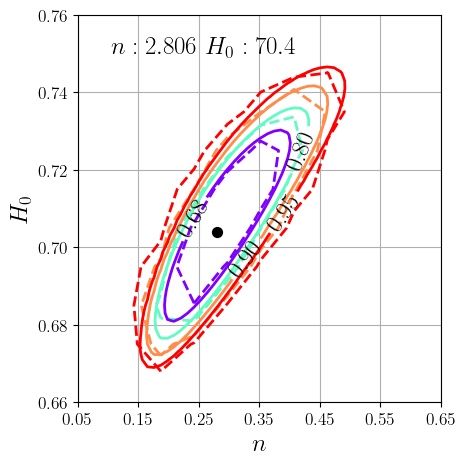

In [22]:
bag.o = bag.x   # use real data
res   = best_fit(nll, dnn, bag)
print(res)

plot_model(test_data, bag, dnn, 
           results=res,
           hist=h2d,
           colormap='rainbow',
           plothist=False,
           filename='fig_phantom_results.pdf')

### Save 95\% confidence set

In [24]:
l0 = test_data.l0.to_numpy() # compute test statistics for real data
n  = test_data.n.to_numpy()
H0 = test_data.H0.to_numpy()

bag.CL = 0.95
select = cdf(l0, n, H0) < bag.CL
n      = n[select]
H0     = H0[select]
print(f'number of points in 95%s set: {len(n):d}' % '%')
cset = pd.DataFrame({'n': n, 'H0': H0})
cset.to_csv('data/type1a_95CL.csv', index=False)

number of points in 95% set: 3758


In [84]:
#%load_ext line_profiler

In [85]:
#%lprun -f generate_coverage_data generate_coverage_data(n[i], H0[i], bag)